#  Synthetic data


### Model 1

To construct the models, we'll need to specify a few things: 

 * *model_type = I* 
 * *model_para = {pvec, N0, T, Nobs}*: 
    * *pvec* : $\mathbf{p}=(p_0, p_1,p_2)$, where $p_0$ is the probability of death, $p_1$ of self-renewal, and $p_2$ is of symmetric division, all of TICs. 
    * *N1* : Number of TICs at $t=0$
    * *T* : Generations. Simulations runs from  $t=0,1,\cdots, T$
    * *Nobs* : Number of observations at each time point $t$
 
In this simulation class, at the end of each cell cycle, DCs die with probability 1 without producing any progenies. TIC, on the other hand, either dies with probability $p_0$, or self-renews to produce tww TICs with probability $p_1$, or differentiates into two DCs with probability $p_2$.


### Model 2
 * *model_type = II* 
 * *model_para = {pvec, N0, T, Nobs}*: 
    * *pvec* : $\mathbf{p}=(p, \lambda, q)$, where $1-p$ is the probability of death, $p(1-\lambda)$ of self-renewal, and $p\lambda$ is of asymmetric division, all of TICs. $q$ is the survival probability of DCs.
    * *N1* : Number of TICs at $t=0$
    * *T* : Geenerations. Simulations runs from  $t=0,1,\cdots, T$
    * *Nobs* : Number of observations at each time point $t$


<img src="files/model-schematic-eps-converted-to.png">

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


sns.set(style="white", font_scale = 2)


%matplotlib inline


class bayesian_TIC:
    
    def __init__(self, model_type = 'I', parameters = {'pvec': [0.0, 0.5, 0.5], 'N1': 100, 'T': 20, 'Nobs': 5}):
        
        # Total number of generations
        self.T = parameters['T'] 
        
        # Number of TICs at t = 0
        self.N1 = parameters['N1']
        
        # Growth parameter
        self.p = parameters['pvec']
        self.type = model_type
        
        
        # Number of observations
        self.Nobs = parameters['Nobs']

        # Allocate 
        
        
        # Initial TIC fraction
        self.renew_obs()
        self.n1all = np.zeros([self.Nobs, self.T+1])
        self.z1all = np.zeros([self.Nobs, self.T+1])
        
        
        self.n2all = np.zeros([self.Nobs, self.T+1])
        self.z2all = np.zeros([self.Nobs, self.T+1])
        
        self.z12all = np.zeros([self.Nobs, self.T+1])
        
        
        self.simulate()
        self.compute_statistics_theory()
        
        
        
        #self.make_figure('time-course')
        #self.make_figure('time-std')
        #self.make_figure('dist')
    
        
    
    def simulate(self):
        
        for i in range(self.Nobs):
            self.renew_obs()
            
            for j in range(self.T):
                self.grow_n_measure()
                   
            self.n1all[i,:] = self.n1
            self.z1all[i,:] = self.z1
            self.n2all[i,:] = self.n2
            self.z2all[i,:] = self.z2
            self.z12all[i,:] = self.z12
        
        self.compute_statistics_empirical()
        
        
        
        
            
            
    def renew_obs(self):
        
        # Initial population [TICs, DCs]
        self.pop = [self.N1, 0]
        
        # Initial TIC fraction
        self.n1 = [1.0]
        self.n2 = [0.0]
        
        # Initial TIC numer
        self.z1 = [self.N1]
        self.z2 = [0]
        
        
        self.z12 = [0]
        
        
    def grow_n_measure(self):
        
        if self.type == 'I':
            cycle = np.random.rand(self.pop[0])
            delta_pop = [(cycle < self.p[0]).sum(), ((cycle >= self.p[0]) & (cycle < self.p[0] + self.p[1])).sum(), ((cycle >= self.p[0] + self.p[1]) & (cycle < 1.0)).sum()]
            self.pop[0] = self.pop[0] - (delta_pop[0] + delta_pop[2]) + delta_pop[1]
            self.pop[1] = 2.0*delta_pop[2]
            self.z1.append(self.pop[0])
            self.z2.append(self.pop[1])
            self.z12.append(self.pop[0]*self.pop[1])
            self.n1.append(float(self.pop[0]/sum(self.pop)))
            self.n2.append(float(self.pop[1]/sum(self.pop)))
            self.pop[1] = 0
            
            
        elif self.type == 'II':
            cycle = np.random.rand(self.pop[0])
            cycle1 = np.random.rand(self.pop[1])
            p0 = 1.0 - self.p[0] # TIC dies
            p1 = self.p[0]*(1.0 -self.p[1]) # TIC self-renews
            delta_pop = [(cycle < p0).sum(), ((cycle >= p0) & (cycle < p0 + p1)).sum(), ((cycle >= p0 + p1) & (cycle < 1.0)).sum()]
            self.pop[0] = self.pop[0] - delta_pop[0] + delta_pop[1]
            
            delta_pop1 = [(cycle1 < 1.0-self.p[2]).sum(), ((cycle1 >= 1.0-self.p[2]) & (cycle1 < 1.0)).sum() ]
            self.pop[1] = self.pop[1] + delta_pop[2]  + delta_pop1[1] - delta_pop1[0]
            self.z1.append(self.pop[0])
            self.z2.append(self.pop[1])
            self.z12.append(self.pop[0]*self.pop[1])
            self.n1.append(float(self.pop[0]/sum(self.pop)))
            self.n2.append(float(self.pop[1]/sum(self.pop)))
            

    def compute_statistics_empirical(self):

        # Density mean and variance for TIC
        self.n1mean = np.mean(self.n1all, axis = 0)
        self.n1var = np.power(np.std(self.n1all, axis = 0), 2)

        # Number mean and variance for TIC
        self.z1mean = np.mean(self.z1all, axis = 0)
        self.z1var = np.power(np.std(self.z1all, axis = 0), 2)


        
        # Density mean and variance for DC
        self.n2mean = np.mean(self.n2all, axis = 0)
        self.n2var = np.power(np.std(self.n2all, axis = 0), 2)

        # Number mean and variance for TIC
        self.z2mean = np.mean(self.z2all, axis = 0)
        self.z2var = np.power(np.std(self.z2all, axis = 0), 2)

        self.z12cov = np.mean(self.z12all, axis = 0) - np.mean(self.z1all, axis = 0)*np.mean(self.z2all, axis = 0)
    
    
    def compute_statistics_theory(self):

        # this function computes the followings:
        #  s1 : number variance of z1
        #  s2 : number variance of z2
        #  cov: covariance Cov(z1, z2)
        #  pk1: mean fraction of z1
        #  pk2: mean fraction of z2
        #  S : variance of n1

       
        s1 = []
        s2 = []
        cov = []
        pk1 = []
        pk2 = []
        S = []


        if self.type == 'I':
            x = 2.0*self.p[1]
            y = 2.0*self.p[2]
            for it in range(1, self.T+1):
                if x != 1.0:
                    s1 = s1 + [x**it *(x**it - 1.0)*2.0*(1-x/2.0)/(x-1.0)]
                    s2 = s2 + [(y**2)*(x**(it-1))*(1.0-(x**(it)))/ (1.0 -x) + y*(x**(it-1))]
                    cov = cov + [y*(x**it)*((1.0 - (x**(it-1)))/(1.0 -x)-(x**(it-1)))]
                else:
                    s1 = s1 + [x**it *it*2.0*(1.0-x/2.0)]
                    s2 = s2 + [(y**2)*(x**(it-1))*(it) + y*(x**(it-1))]
                    cov = cov + [y*(x**it)*(it-1-(x**(it-1)))]

                
                pk1 = pk1 + [x / (x+y)]
                pk2 = pk2 + [1.0-pk1[-1]]
                S  = S  + [s1[-1]*(1.0 - pk1[-1])**2 + s2[-1]*(pk1[-1]**2) - 2.0*cov[-1]*pk1[-1]*(1.0 - pk1[-1])]
            self.s1 = s1
            self.s2 = s2
            self.cov = cov
            self.pk1 = pk1
            self.pk2 = pk2
            self.S = S
        
        
        elif self.type == 'II':
            x = self.p[0] # p
            y = self.p[1] # lambda
            z = self.p[2] # q

            for it in range(1, self.T+1):
                s1  = s1  + [(x**(it))*(2.0-y)**(it-1)*((2.0-y)*(1.0-(x*(2.0-y))**it) + 2.0*it*(1.0-y))]
                pk1 = pk1 + [(x*(2.0-y))**(it)*(2*z-x*(2-y)) /(2.0*(z-x)*(x*(2-y))**it + x*y*(2*z)**it)]
                b22t = 0.0
                
                for iit in range(1, it):
                    if 2*z == x*(2.0-y):
                        m12 = x*y*iit*(x*(2.0-y))**(iit-1)
                    else:
                        m12 = x*y*((2*z)**iit -(x*(2.0 - y))**iit)/(2*z - x*(2.0-y))
                    
                    if 2*z == 1.0:
                        b22t += (m12*m12*2*x*(1.0-y) + (x*y*(2*z)**iit)*(2*m12+ iit))*(x*(2.0-y))**(it-1-iit)
                    else:
                        b22t += (m12*m12*2*x*(1.0-y) + (x*y*(2*z)**iit)*(2*m12+ (1.0-(2*z)**iit)/(1.0-2*z)))*(x*(2.0-y))**(it-1-iit)
                
                s2 = s2 + [b22t + (2*z)**it - (2*z)**(2*it)]

                
                if 2*z == x*(2.0-y) and 2*z == 1.0:
                    at = 1.0 + it-1.0
                elif 2*z == x*(2.0-y) and 2*z != 1.0:
                    at = 1.0 + 2*z*(1.0-(2*z)**(it-1))/ (1-2*z)
                elif 2*z == 1.0 and x*(2-y) != 1.0:
                    at = 1.0 + (2*z*(2*z-x*y)*(it-1) - 2*x*(1.0-y)*(x*(2.0-y))*(1.0 - (x*(2.0-y))**(it-1))/(1.0-x*(2-y))) /(2*z - x*(2.0-y))
                elif 2*z != 1.0 and x*(2-y) == 1.0:
                    at = 1.0 + (2*z*(2*z-x*y)*(1.0-(2*z)**(it-1))/(1.0-2.0*z) - 2*x*(1.0-y)*(x*(2.0-y))*(it-1)) /(2*z - x*(2-y))
                else:
                    at = 1.0 + (2*z*(2*z-x*y)*(1.0-(2*z)**(it-1))/(1.0-2.0*z) - 2*x*(1.0-y)*(x*(2.0-y))*(1.0 - (x*(2.0-y))**(it-1))/(1.0-x*(2.0-y))) /(2*z - x*(2-y))

                if 2*z == x*(2.0-y):
                    m12t = x*y*it*(x*(2.0-y))**(it-1)
                else:
                    m12t = x*y*((2*z)**it -(x*(2.0 - y))**it)/(2*z - x*(2.0-y))
                cov = cov + [at*y*(x**it)*(2.0 -y)**(it-1)-((x*(2.0-y))**it)*m12t]
                pk2 = pk2 + [1.0-pk1[-1]]
                S  = S  + [s1[-1]*(1.0 - pk1[-1])**2 + s2[-1]*(pk1[-1]**2) - 2.0*cov[-1]*pk1[-1]*(1.0 - pk1[-1])]

            
            self.s1 = s1
            self.s2 = s2
            self.pk1 = pk1
            self.cov = cov
            self.pk1 = pk1
            self.pk2 = pk2
            self.S = S

    
    def make_figure(self, fig_type):
        
        if fig_type == 'number':
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
            fs = 18 # font size
            fs_s = 15 # small text font size
            ms = 5 # marker size
            ms_s = 2
            lw = 3 # line width size
            
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, wspace = 0.4)

            t= range(self.T+1)
            ax1.text(0.08, 0.99, 'A', transform=fig.transFigure, fontsize=fs, fontweight='bold', va='top')
            ax1.errorbar(t, self.z1mean, yerr= np.sqrt(self.z1var), fmt='o' ,markersize = 8, label = 'simulation')
            #ax.legend(loc='upper left')
            ax1.set_xlabel(r' $t$, generations', multialignment='left', fontweight='bold', fontsize=fs)
            ax1.set_ylabel(r'TIC count, $Z_1$', fontweight='bold', fontsize=fs)
            ax1.tick_params(axis='both', which='major', labelsize=fs)
    
            
            ax2.text(0.33, 0.99, 'B', transform=fig.transFigure, fontsize=fs, fontweight='bold', va='top')
            ax2.errorbar(t, self.z2mean, yerr= np.sqrt(self.z2var), fmt='o' ,markersize = 8, label = 'simulation')
            ax2.set_xlabel(r' $t$, generations', multialignment='left', fontweight='bold', fontsize=fs)
            ax2.set_ylabel(r'DC count, $Z_2$', fontweight='bold', fontsize=fs)
            ax2.tick_params(axis='both', which='major', labelsize=fs)
        
            ax3.text(0.57, 0.99, 'C', transform=fig.transFigure, fontsize=fs, fontweight='bold', va='top')
            ax3.plot(t, self.z2mean+ self.z1mean, 'o',markersize = 8, label = 'simulation')
            ax3.set_yscale('log')
            ax3.set_xlabel(r' $t$, generations', multialignment='left', fontweight='bold', fontsize=fs)
            ax3.set_ylabel(r'Cell count, $Z_1 + Z_2$', fontweight='bold', fontsize=fs)
            ax3.tick_params(axis='both', which='major', labelsize=fs)
            
            fig_str = 'Delta_T' + str(self.T) + '_Nobs' + str(self.Nobs) + '_N0' + str(self.N1) + '_pvec' + str(self.p[0])  + '_' + str(self.p[1])  + 'type_' + self.type
            #fig.savefig( fig_str +'.png', bbox_inches='tight')
            #fig.savefig( fig_str +'.pdf', bbox_inches='tight')
        
        elif fig_type == 'mean-fraction':
            
            fig, ax = plt.subplots(figsize=(6,6))
            fs = 18 # font size
            fs_s = 15 # small text font size
            ms = 5 # marker size
            ms_s = 2
            lw = 3 # line width size


            t= range(self.T+1)
            ax.errorbar(t, self.n1mean, yerr= np.sqrt(self.n1var), fmt='o' ,markersize = 8, label = 'simulation')
            ax.plot(t, np.insert(self.pk1,0,1.0), color='black', linestyle = '--',lw=2, label = 'theory')
            #ax.legend(loc='upper left')
            ax.set_xlabel(r' $t$, generations', multialignment='left', fontweight='bold', fontsize=fs)
            ax.set_ylabel(r'TIC fraction, $n_1$', fontweight='bold', fontsize=fs)
            ax.tick_params(axis='both', which='major', labelsize=fs)
            ax.legend(loc='upper right', fontsize = 'xx-large')
            fig_str = 'Delta_T' + str(self.T) + '_Nobs' + str(self.Nobs) + '_N0' + str(self.N1) + '_pvec' + str(self.p[0])  + '_' + str(self.p[1])  + 'type_' + self.type
            #fig.savefig( fig_str +'.png', bbox_inches='tight')
            fig.savefig( fig_str +'.pdf', bbox_inches='tight')
        
        elif fig_type == 'number-var':
            
            # set up figure
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
            fs = 18 # font size
            fs_s = 15 # small text font size
            ms = 5 # marker size
            ms_s = 2
            lw = 3 # line width size
            
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, wspace = 0.4)
            
            t= range(self.T+1)
            
            ax1.text(0.08, 0.99, 'A', transform=fig.transFigure, fontsize=fs, fontweight='bold', va='top')
            ax1.plot(t, self.z1var, 'bo',markersize = 8, label = 'simulation')
            ax1.plot(t, np.insert(self.s1,0,0), 'k--',lw=2, label = 'theory')
            ax1.set_xlabel(r' $t$, generations', multialignment='left', fontweight='bold', fontsize=fs)
            ax1.set_ylabel(r'TIC number variance, $\sigma^2_1$', fontweight='bold', fontsize=fs)
            ax1.legend(loc='upper right', fontsize=fs_s)
            #ax.grid()
            ax1.tick_params(axis='both', which='major', labelsize=fs)

            ax2.text(0.33, 0.99, 'B', transform=fig.transFigure, fontsize=fs, fontweight='bold', va='top')
            ax2.plot(t, self.z2var, 'bo',markersize = 8, label = 'simulation')
            ax2.plot(t, np.insert(self.s2,0,0), 'k--',lw=2, label = 'theory')
            ax2.set_xlabel(r' $t$, generations', multialignment='left', fontweight='bold', fontsize=fs)
            ax2.set_ylabel(r'DC number variance, $\sigma^2_2$', fontweight='bold', fontsize=fs)
            ax2.legend(loc='upper right', fontsize=fs_s)
            #ax.grid()
            ax2.tick_params(axis='both', which='major', labelsize=fs)
            
            ax3.text(0.57, 0.99, 'C', transform=fig.transFigure, fontsize=fs, fontweight='bold', va='top')
            ax3.plot(t, self.z12cov, 'bo',markersize = 8, label = 'simulation')
            ax3.plot(t, np.insert(self.cov,0,0), 'k--',lw=2, label = 'theory')
            ax3.set_xlabel(r' $t$, generations', multialignment='left', fontweight='bold', fontsize=fs)
            ax3.set_ylabel(r'Cell number covariance, $\Sigma^{12}$', fontweight='bold', fontsize=fs)
            ax3.legend(loc='upper right', fontsize=fs_s)
            #ax.grid()
            ax3.tick_params(axis='both', which='major', labelsize=fs)
            
            
            
            fig_str = 'sigma_T' + str(self.T) + '_Nobs' + str(self.Nobs) + '_N0' + str(self.N1) + '_pvec' + str(self.p[0])  + '_' + str(self.p[1]) + 'type_' + self.type
            #fig.savefig( fig_str +'.png', bbox_inches='tight')
            #fig.savefig( fig_str +'.pdf', bbox_inches='tight')
        

### Here we show how to run this simulation class

* First create a parameter dictionary that we'll use to simulate named *parameters*.
* Create an instance of class object named *g* with parameters given by *parameters*. 
* Use the plot functions in *g* to make plots. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars


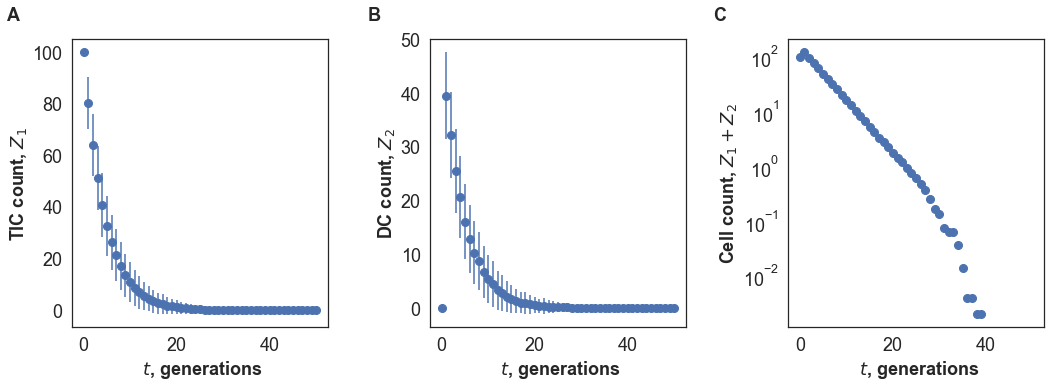

In [76]:
parameters = {'pvec': [0.4, 0.4, 0.2], 'N1': 100, 'T': 50, 'Nobs': 1000}


# The theory curve is calculated with N0= 1
g = bayesian_TIC(model_type = 'I',parameters = parameters)
#print(g.z12cov)
g.make_figure('number')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars


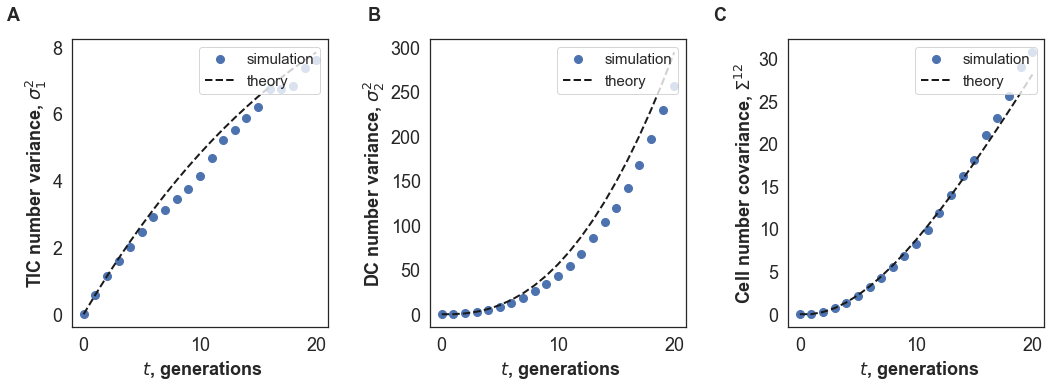

In [22]:
parameters = {'pvec': [0.7, 0.6, 0.5], 'N1': 1, 'T': 20, 'Nobs': 5000}

g = bayesian_TIC(model_type = 'II', parameters = parameters)
g.make_figure('number-var')